In [4]:
import torch

import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import models

In [5]:
from preprocess import preprocess

Because the pre-trained model did not perform very well, some modifications were introduced. 

In the next test, only the initial layers of the network were used, because they are responsible for recognizing more general patterns and focused and low-level features which makes it suitable for using pre-trained.
On top of them some new convolutional layers were added and set to be trainable, allowing to adjust weights in new CNN layers and as a result to learn more dataset-specific features.

### Preprocessing

In [6]:
dataset = torch.load("dataset.pth")

In [7]:
weights = torch.load("weights.pth")

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

In [9]:
trainloader,testloader,valloader = preprocess(dataset, 64, transform)

In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

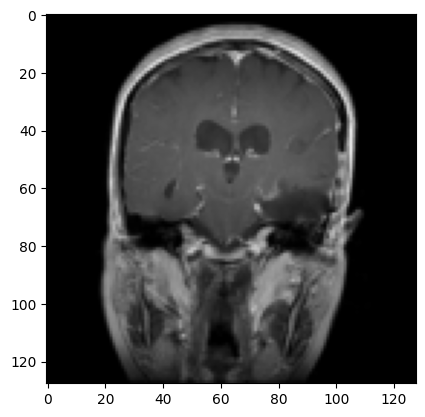

tensor(1)


In [11]:
sample_id = 10

img = images[sample_id].permute(1, 2, 0).numpy()
plt.imshow(img)

plt.show()

print(labels[sample_id])

### Model

In [12]:
efficient_net = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

In [13]:
base = nn.Sequential(*list(efficient_net.features[:2]))
avg = efficient_net.avgpool

In [14]:
base

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

For the new custom model, the first 2 feature extraction layers of EfficientNet were used, and incorporated in a custom model that enables them to enrich with additional trainable convolutional layers, followed by linear layers that gradually reduced the output size. Different output channels of CNN were tested and batch ormalisation was added to stabilize the learning process

In [15]:
backbone = base
avg = avg

conv = nn.Conv2d(16, 64, 3)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(64, 128, 7)
conv3 = nn.Conv2d(128, 256, 9)

# conv2 = nn.Conv2d(16, 64, 3)
# conv3 = nn.Conv2d(64, 128, 7)

fc1 = nn.Linear(256*2*2 , 512)
fc2 = nn.Linear(512, 128)
fc3 = nn.Linear(128, 16)
fc4 = nn.Linear(16, 2)
dropout = nn.Dropout(p=0.2)


x=images[sample_id].unsqueeze(0)

x = backbone(x)
# x = avg(x)
x = conv(x)
x = pool(x)
x = conv2(x)
x = pool(x)
x = conv3(x)
x = pool(x)

# x = torch.flatten(x)

# x = F.relu(fc1(x))
# x = dropout(x)
# x = F.relu(fc2(x))
# x= dropout(x)
# x = F.relu(fc3(x))
# x = fc4(x)

x.shape


torch.Size([1, 256, 2, 2])

In [16]:
class EffNetBasedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = base
        self.avg = avg

        self.conv = nn.Conv2d(16, 64, 3)
        self.norm = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 9)
        self.norm3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*2*2 , 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0.3)

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)

        x = self.conv(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.pool(x)

        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x= self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [ ]:
model = EffNetBasedModel(os.getenv("DEVICE"))

In [ ]:
device = torch.device()
model.to(device)

EffNetBasedModel(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [19]:
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

In [20]:
train_loss_plot = []
test_loss_plot = []

In [21]:
best_result = np.inf
test_loss_array = []
n_epochs = 15
patience = 5

for epoch in range(n_epochs):

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(model.state_dict(), "./efficient_based_custom.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.001) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 1.2954085543751717, Test loss: 1.2163602113723755
Epoch: 1, Train loss: 1.0932315727695823, Test loss: 1.0693265199661255
Epoch: 2, Train loss: 0.8589810393750668, Test loss: 0.9452047944068909
Epoch: 3, Train loss: 0.6435854649171233, Test loss: 0.9612066745758057
Epoch: 4, Train loss: 0.49815669003874063, Test loss: 1.1422019004821777
Epoch: 5, Train loss: 0.41418648324906826, Test loss: 0.6352000832557678
Epoch: 6, Train loss: 0.3183871223591268, Test loss: 1.1085610389709473
Epoch: 7, Train loss: 0.2737651572097093, Test loss: 0.7245233654975891
Epoch: 8, Train loss: 0.20771319547202438, Test loss: 2.3920609951019287


### Results

The training process was less stable, with a slight decrease of test loss at the beginning and then sudden increase, probably caused by an overfit.

In [22]:
model.load_state_dict(torch.load("./efficient_based_custom.pth"))

<All keys matched successfully>

<Axes: >

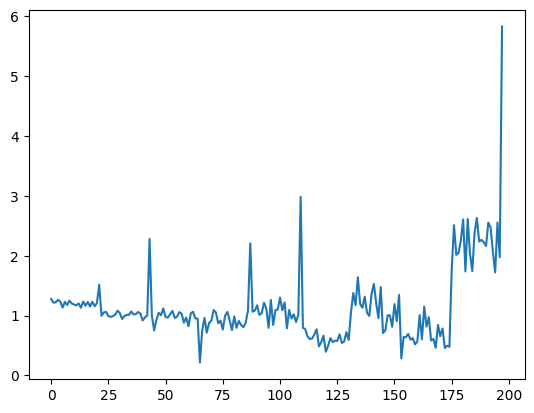

In [23]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

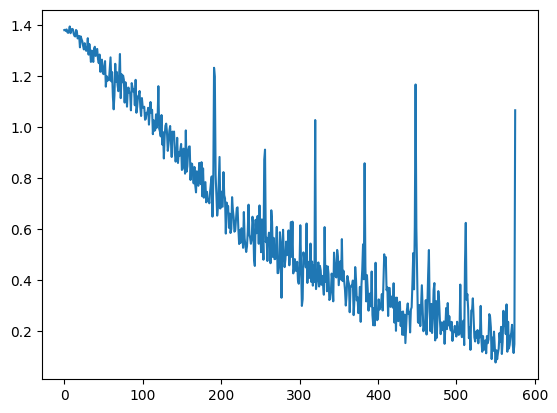

In [24]:
sns.lineplot(data = train_loss_plot)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [26]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = model(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


The results are definitely lower comparing to other tests, it may be caused by some incompatibility of the initial layers with the additional, trainable ones or differences in weights pre-trained on RGB and not grayscale, after some tests with different configurations of these combined model, no result was similar to the ones achieved using different techniques so this method was rejected.

In [27]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.46448863636363635
0.40513561465440245
0.6642556406837764
0.4417958546017045
